In [3]:
!pip install causalnex

     |████████████████████████████████| 140 kB 6.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 1.9 MB 38.3 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.11.2-cp37-cp37m-linux_x86_64.whl size=68515 sha256=821821b1653153ad9faab93eeb24ef5ab1bcde8ac2555493d0c386302f7be185
  Stored in directory: /root/.cache/pip/wheels/23/5f/62/304b411f20be41821465a82bc98baabc5e68c3cdd1eb99db71
Successfully built wrapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.12.1
    Uninstalling wrapt-1.12.1:
      Successfully uninstalled wrapt-1.12.1
ERROR: pip's dependency resolver does not currently take into account all t

In [14]:
!pip install tensorflow 2.6.0 upgrade

ERROR: Could not find a version that satisfies the requirement 2.6.0 (from versions: none)
ERROR: No matching distribution found for 2.6.0


In [15]:
!pip install wrapt~=1.12.1

In [17]:
import causalnex
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

from causalnex.structure import StructureModel
sm=StructureModel

In [18]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [28]:
df= pd.read_csv('/content/gdrive/MyDrive/academy/week7/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [29]:

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket


from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score

from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Markdown, display, Image, display_html

In [30]:
!pip install graphviz

In [31]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [32]:
def labeler(value):
  ''' Return 1 if value is M, and return 0 other wise'''
  if(value == 'M'): return 1
  if(value == 'B'): return 0
  else: return None

In [33]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [34]:
x = df[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,perimeter_se,radius_se,compactness_worst,compactness_mean,texture_worst,concave points_se,smoothness_worst,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,2019.0,25.38,0.2654,0.14710,122.80,1001.0,17.99,153.40,0.3001,0.7119,8.589,1.0950,0.6656,0.27760,17.33,0.01587,0.1622,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,1,158.80,1956.0,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,0.0869,0.2416,3.398,0.5435,0.1866,0.07864,23.41,0.01340,0.1238,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,1,152.50,1709.0,23.57,0.2430,0.12790,130.00,1203.0,19.69,94.03,0.1974,0.4504,4.585,0.7456,0.4245,0.15990,25.53,0.02058,0.1444,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,1,98.87,567.7,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,0.2414,0.6869,3.445,0.4956,0.8663,0.28390,26.50,0.01867,0.2098,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,1,152.20,1575.0,22.54,0.1625,0.10430,135.10,1297.0,20.29,94.44,0.1980,0.4000,5.438,0.7572,0.2050,0.13280,16.67,0.01885,0.1374,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883


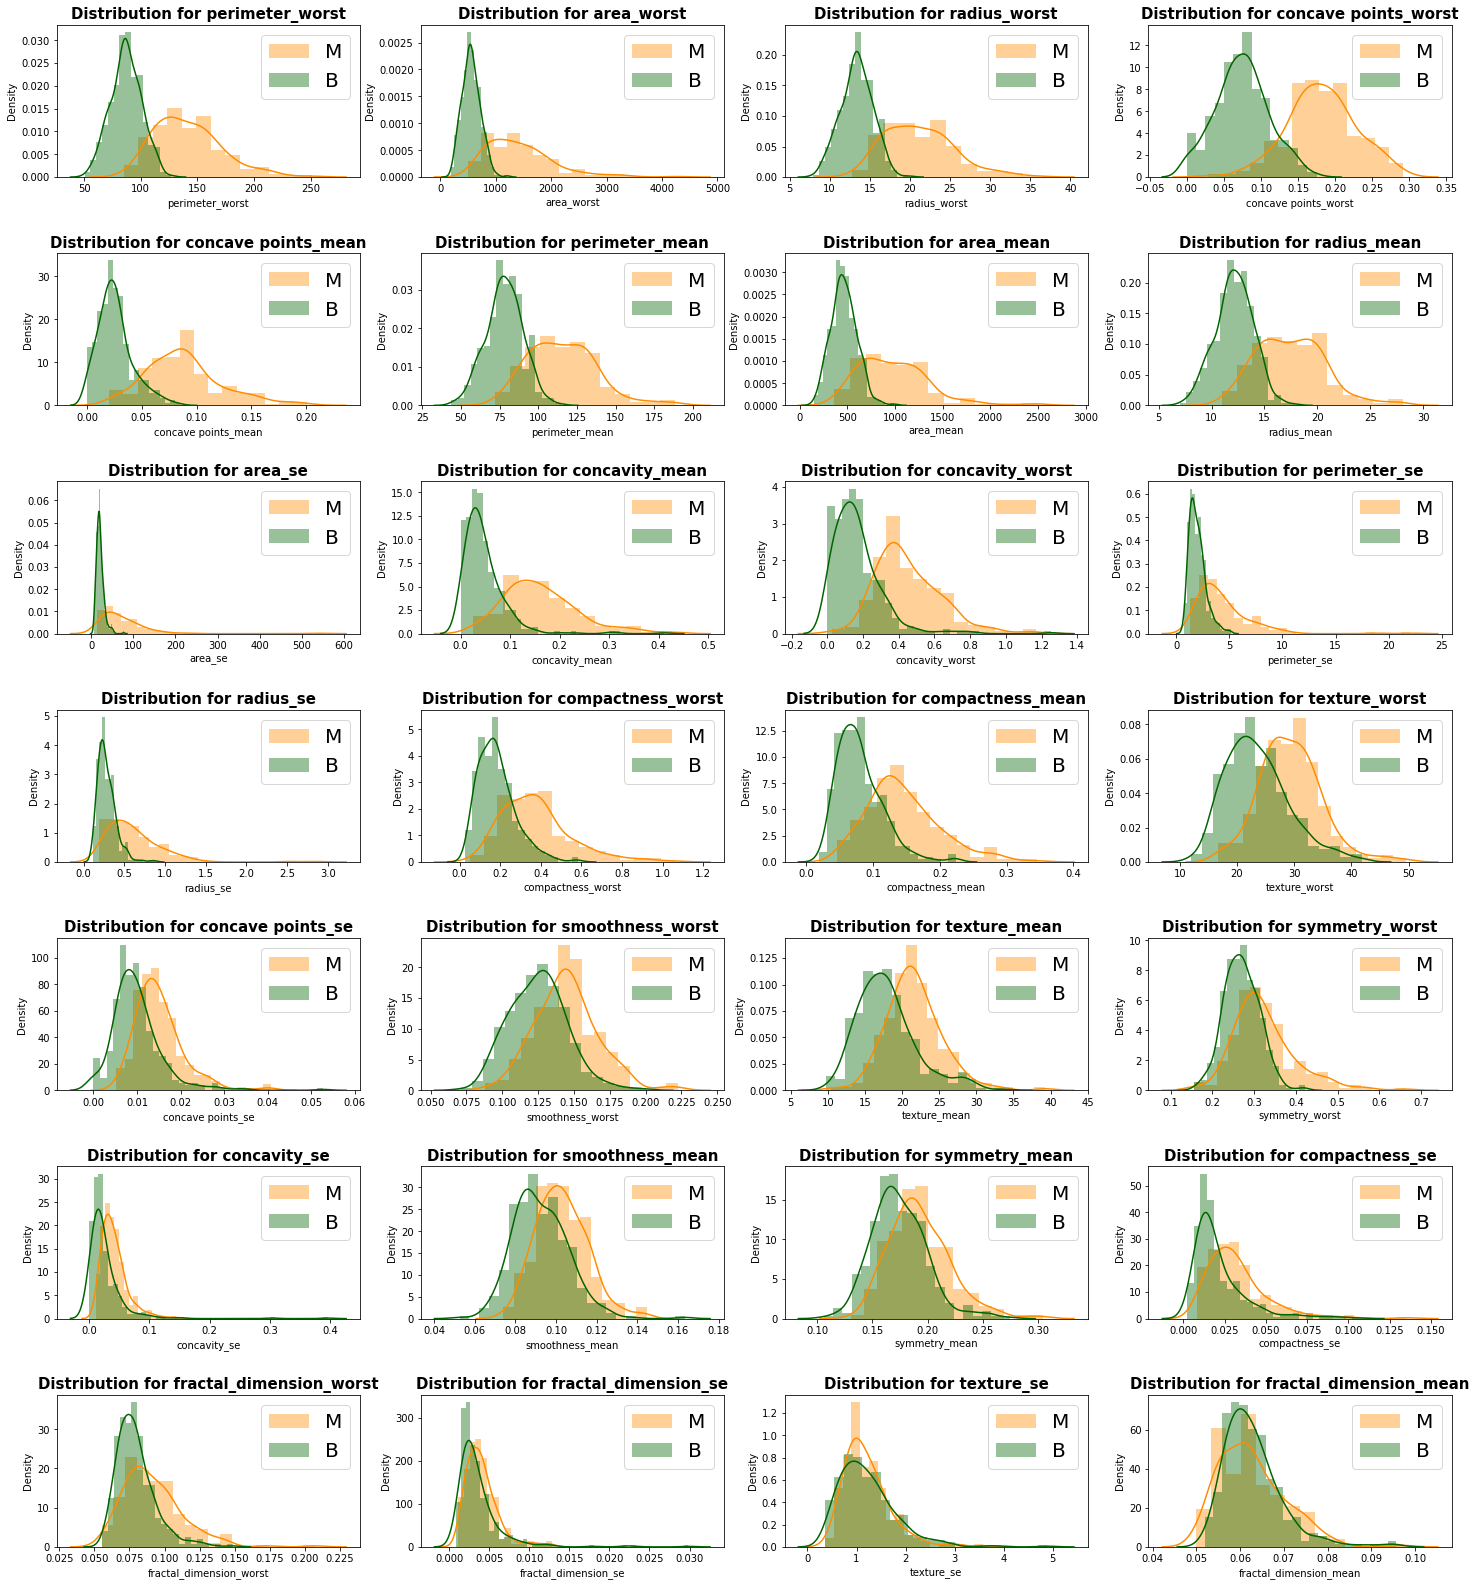

In [35]:

num_feat = x.shape[1]-1
fig = plt.figure(figsize=(25, num_feat))
fig.subplots_adjust(hspace=.5)
axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

for i, column in enumerate(x.columns[1:]):
    sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='darkorange', label="M")
    sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='darkgreen', label="B")
    axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
    axs[i].legend(fontsize=20)
plt.show()

In [36]:
%%time
sm = from_pandas(x.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

CPU times: user 3min 54s, sys: 2min 58s, total: 6min 53s
Wall time: 3min 31s


In [37]:
def vis_sm(sm):
  viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

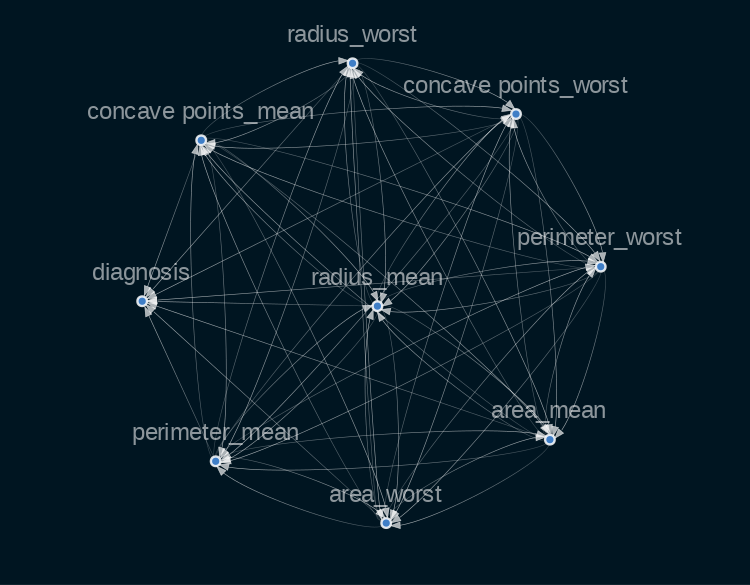

In [38]:
vis_sm(sm)

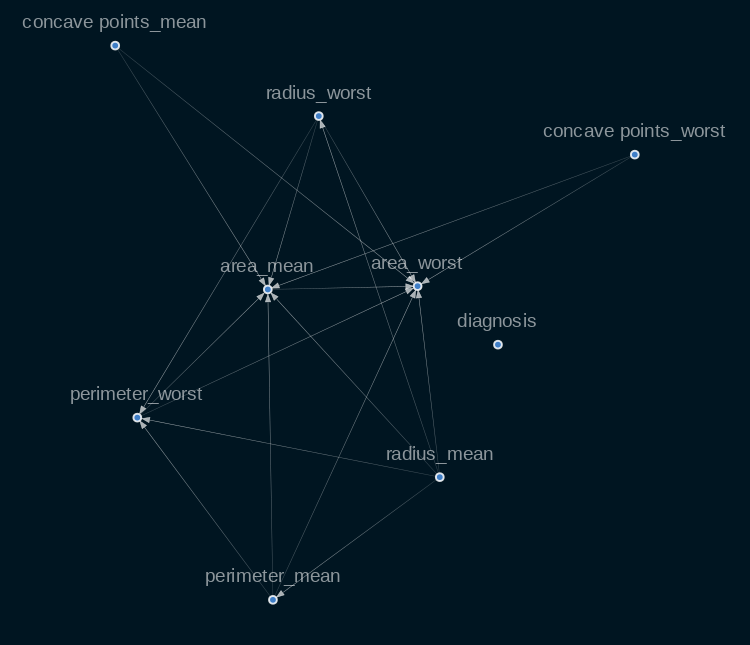

In [39]:
sm.remove_edges_below_threshold(0.8)
vis_sm(sm)

In [40]:
# 50%
x_selected = x.iloc[:, :10]
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

In [41]:
%%time
sm1 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm1 = sm1.get_largest_subgraph()
vis_sm(sm1)

CPU times: user 2min 10s, sys: 1min 37s, total: 3min 48s
Wall time: 1min 56s


In [42]:
# 60 %
portion = int(x_selected.shape[0]*.6)
x_portion = x_selected.head(portion)


In [43]:
%%time
sm2 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm2 = sm2.get_largest_subgraph()
vis_sm(sm2)

CPU times: user 2min 58s, sys: 2min 12s, total: 5min 11s
Wall time: 2min 39s


In [44]:
# 70%
portion = int(x_selected.shape[0]*.7)
x_portion = x_selected.head(portion)

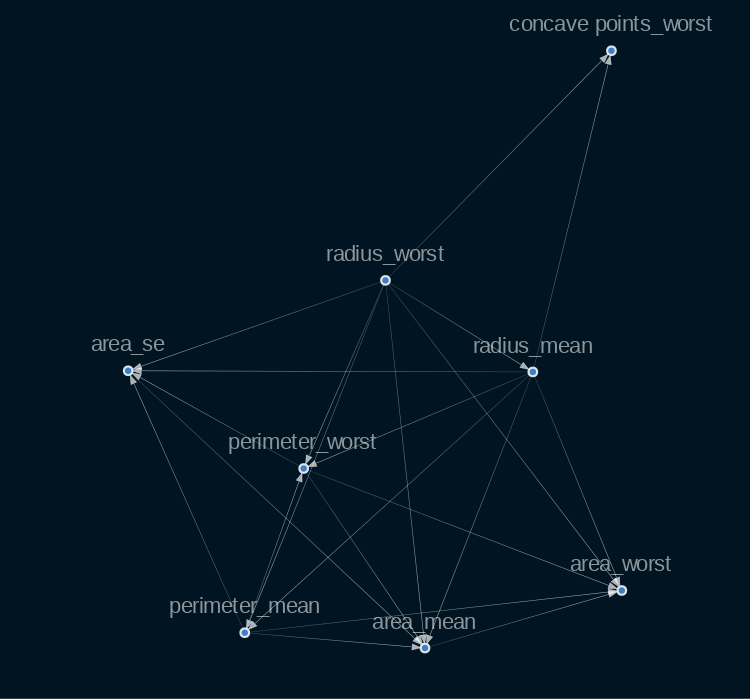

In [45]:
sm3 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm3 = sm3.get_largest_subgraph()
vis_sm(sm3)


In [46]:
  # 80%
portion = int(x_selected.shape[0]*.8)
x_portion = x_selected.head(portion)

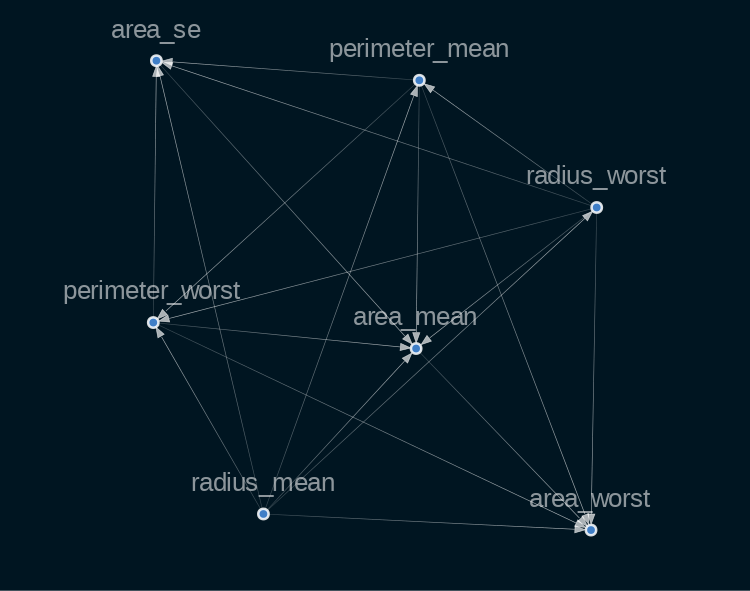

In [47]:

sm4 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm4 = sm4.get_largest_subgraph()
vis_sm(sm4)

In [48]:
a = np.array(sm1.edges)
b = np.array(sm2.edges)

In [49]:
a

array([['perimeter_worst', 'area_worst'],
       ['perimeter_worst', 'area_mean'],
       ['perimeter_worst', 'area_se'],
       ['radius_worst', 'perimeter_worst'],
       ['radius_worst', 'area_worst'],
       ['radius_worst', 'perimeter_mean'],
       ['radius_worst', 'area_mean'],
       ['radius_worst', 'area_se'],
       ['perimeter_mean', 'area_worst'],
       ['perimeter_mean', 'area_mean'],
       ['area_mean', 'area_worst'],
       ['radius_mean', 'area_worst'],
       ['radius_mean', 'radius_worst'],
       ['radius_mean', 'perimeter_mean'],
       ['radius_mean', 'area_mean'],
       ['radius_mean', 'area_se'],
       ['area_se', 'area_mean']], dtype='<U15')

In [50]:
print(a.shape)
b

(17, 2)


array([['perimeter_worst', 'area_worst'],
       ['perimeter_worst', 'area_mean'],
       ['perimeter_worst', 'area_se'],
       ['radius_worst', 'perimeter_worst'],
       ['radius_worst', 'area_worst'],
       ['radius_worst', 'area_mean'],
       ['radius_worst', 'area_se'],
       ['perimeter_mean', 'area_worst'],
       ['perimeter_mean', 'area_mean'],
       ['area_mean', 'area_worst'],
       ['radius_mean', 'area_worst'],
       ['radius_mean', 'perimeter_mean'],
       ['radius_mean', 'area_mean'],
       ['radius_mean', 'area_se'],
       ['area_se', 'area_mean']], dtype='<U15')

In [52]:
from sklearn.metrics import jaccard_score
#jaccard_score(a, b, average='samples')

In [54]:
# final graph
%%time
sm = from_pandas_lasso( x_selected,
                        tabu_parent_nodes=['diagnosis'], 
                        w_threshold=0.3, 
                        beta=0.8)

CPU times: user 2min 24s, sys: 1min 46s, total: 4min 11s
Wall time: 2min 8s


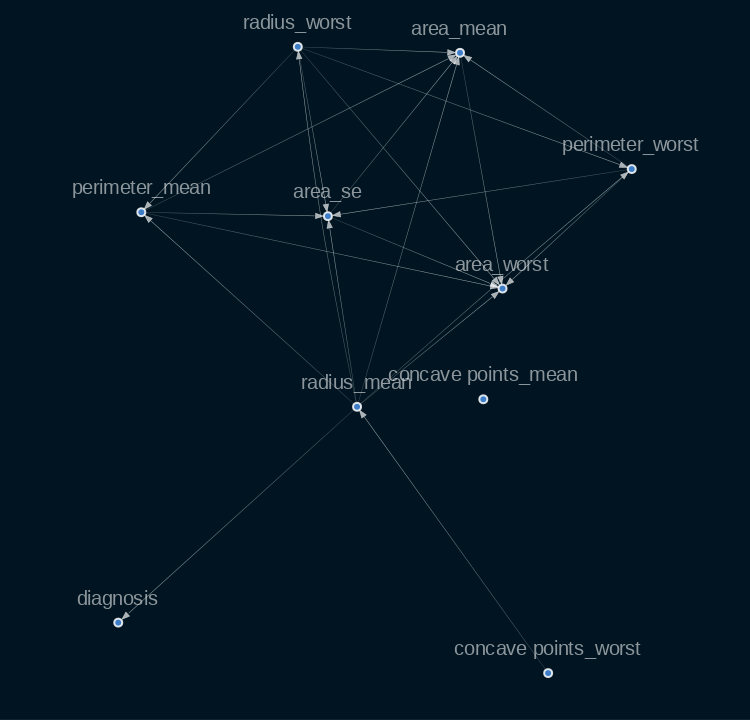

In [55]:
vis_sm(sm)

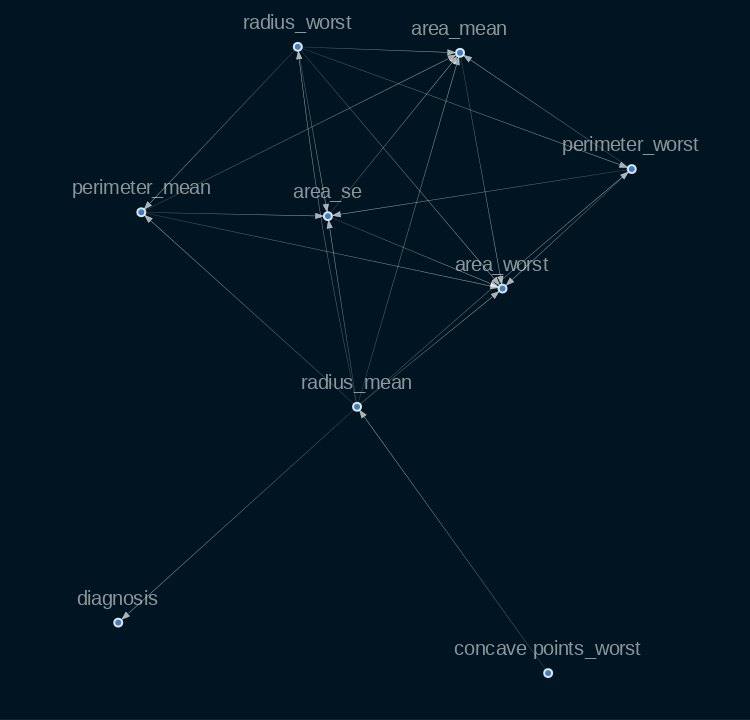

In [56]:
sm = sm.get_largest_subgraph()
vis_sm(sm)

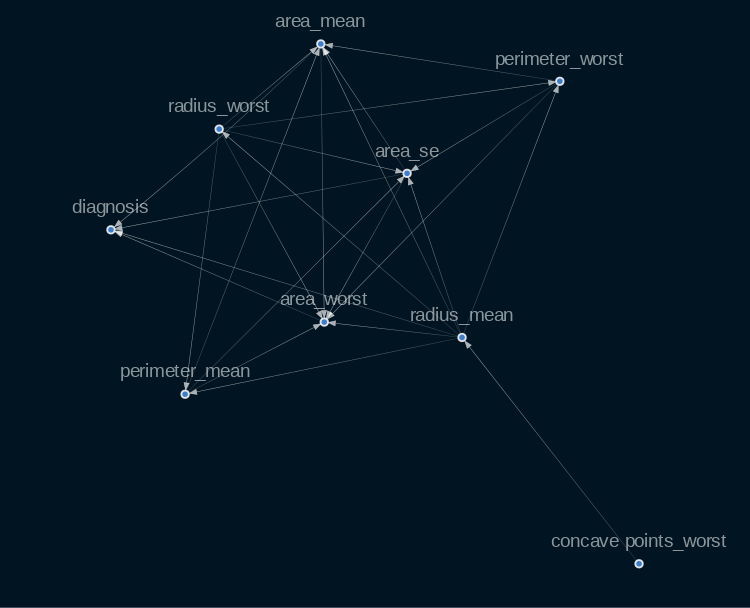

In [57]:
sm.add_edge("area_mean", "diagnosis")
sm.add_edge("area_se", "diagnosis")
sm.add_edge("area_worst", "diagnosis")
vis_sm(sm)

Reducing a graph to its Markov Blanket¶
Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically,


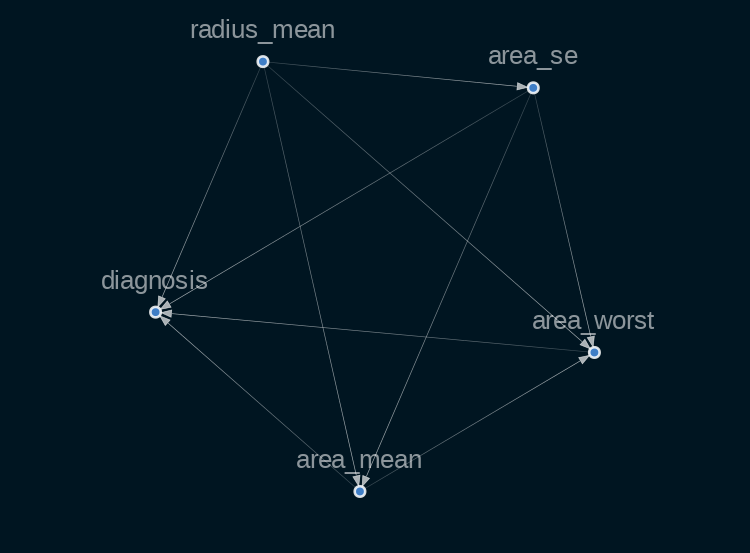

In [58]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list
vis_sm(blanket.structure)

Discretising Numeric Features¶


In [59]:
class DfOverview:
    """
        Give an overview for a given data frame, 
        like null persentage for each columns, 
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def unique_values(self) -> None:
        return [self.getUniqueCount(column) for column in self.df]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _labels = [column for column in self.df]  # Only numeric columns
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'label',
            'count',
            'none_count',
            'none_percentage',
            'unique_value_count',
            'unique_percentage',
            'dtype']
        data = zip(
            _labels,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        new_df.set_index('label', inplace=True)
        new_df.sort_values(by=["none_count"], inplace=True)
        return new_df

In [60]:
def view_df(df, subset=[], color='#66F582'):
    df = df.reset_index()
    style = df.style.set_table_attributes("style='display:inline'").\
        bar(subset=subset, axis=1, color=color)\
        .format({"label": lambda x: x.upper()})\
        .set_properties(**{'background-color': 'white', 'color': 'black'})
    display_html(style._repr_html_(), raw=True)

In [61]:
df_overview = DfOverview(x_selected)
overview = df_overview.getOverview()
view_df(overview[["count", "unique_value_count", "unique_percentage"]],
                    ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,514,90.33%
2,AREA_WORST,569,544,95.61%
3,RADIUS_WORST,569,457,80.32%
4,CONCAVE POINTS_WORST,569,492,86.47%
5,CONCAVE POINTS_MEAN,569,542,95.25%
6,PERIMETER_MEAN,569,522,91.74%
7,AREA_MEAN,569,539,94.73%
8,RADIUS_MEAN,569,456,80.14%
9,AREA_SE,569,528,92.79%


In [62]:
features = list(x_selected.columns.difference(['diagnosis']))
features

['area_mean',
 'area_se',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'perimeter_mean',
 'perimeter_worst',
 'radius_mean',
 'radius_worst']

In [63]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode='single',
    tree_params={'max_depth': 5, 'random_state': 27},
)
tree_discretiser.fit(
    feat_names=features,
    dataframe=x,
    target_continuous=True,
    target='diagnosis',
)
tree_discretiser

DecisionTreeSupervisedDiscretiserMethod(tree_params={'max_depth': 5,
                                                     'random_state': 27})

In [64]:
discretised_data = x_selected.copy()
for col in features:
    discretised_data[col] = tree_discretiser.transform(x_selected[[col]])

In [65]:
df_overview = DfOverview(discretised_data)
overview = df_overview.getOverview()
view_df(overview[["count", "unique_value_count", "unique_percentage"]],
           ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,DIAGNOSIS,569,2,0.35%
1,PERIMETER_WORST,569,20,3.51%
2,AREA_WORST,569,18,3.16%
3,RADIUS_WORST,569,18,3.16%
4,CONCAVE POINTS_WORST,569,23,4.04%
5,CONCAVE POINTS_MEAN,569,17,2.99%
6,PERIMETER_MEAN,569,21,3.69%
7,AREA_MEAN,569,20,3.51%
8,RADIUS_MEAN,569,22,3.87%
9,AREA_SE,569,21,3.69%


Reducing a graph to its Markov Blanket¶
Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically

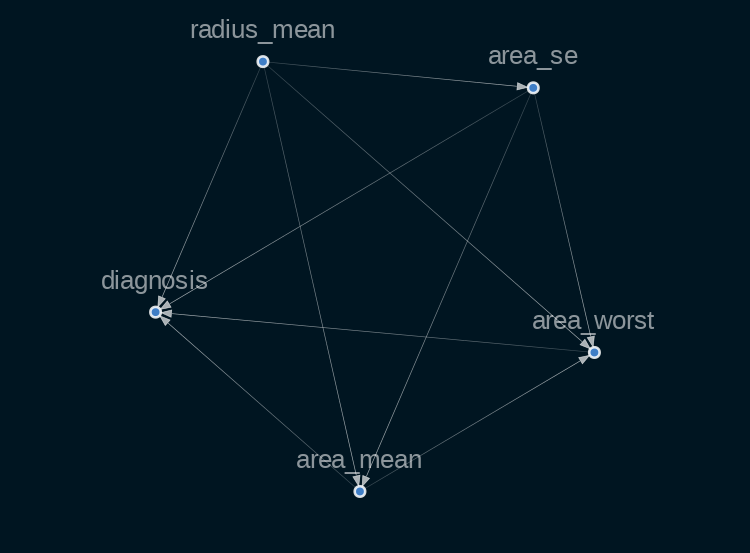

In [66]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list
vis_sm(blanket.structure)

Check for stability of the graph¶


In [67]:
x_selected.shape[0]


569

In [68]:
portion = int(x_selected.shape[0] / 2)
x_portion = x_selected.head(portion)

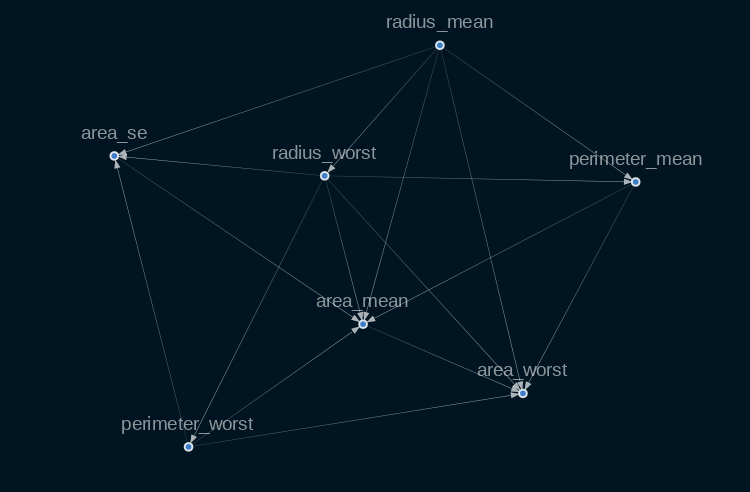

In [69]:

sm = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm = sm.get_largest_subgraph()
vis_sm(sm)

In [70]:
portion = int(x_selected.shape[0]*2 / 3)
x_portion = x_selected.head(portion)

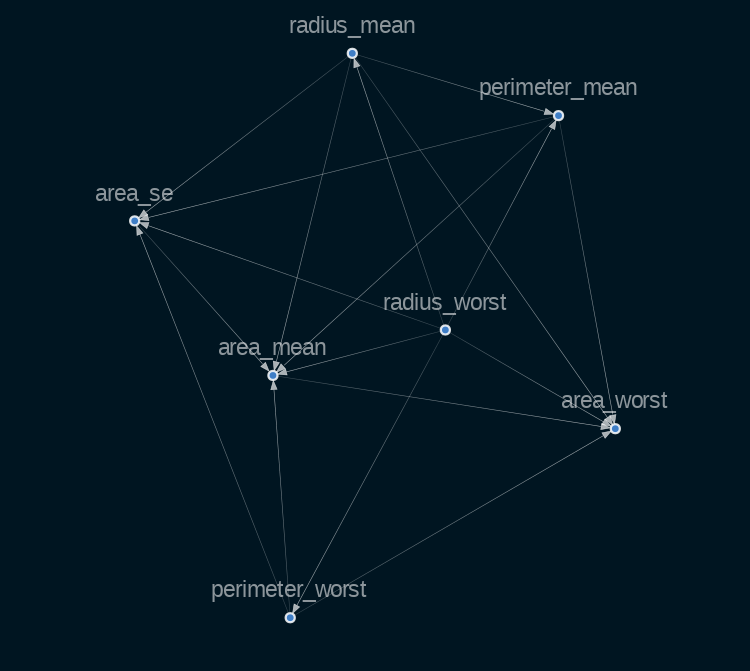

In [71]:

sm = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm = sm.get_largest_subgraph()
vis_sm(sm)

Like many other machine learning models, we will use a train and test split to help us validate our findings.


In [77]:

# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

 **Model Probability**
 
With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

In [79]:
bn = bn.fit_node_states(discretised_data)


In [79]:

bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

Predict the State given the Input Data

The predict method of BayesianNetwork allows us to make predictions based on the data using the learnt Bayesian Network. 

In [ ]:
discretised_data.loc[18, discretised_data.columns != 'diagnosis']


In [ ]:
predictions = bn.predict(discretised_data, "diagnosis")


In [ ]:
print('The prediction is \'{prediction}\''.format(prediction=predictions.loc[18, 'G1_prediction']))


The prediction by the Bayesian Network turns out to be a Fail. Let’s compare this to the ground truth:

Model Quality

Classification Report

In [ ]:
from causalnex.evaluation import classification_report
classification_report(bn, test, "diagnosis")

**ROC / AUC**

Receiver Operating Characteristics (ROC), and the Area Under the ROC Curve (AUC) can be obtained using the roc_auc method within the CausalNex metrics module. Again, a test set and target node must be provided.

In [ ]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "diagnosis")
print(auc)

Querying Marginals

Baseline Marginals

To query the model for baseline marginals that reflect the population as a whole, a query method can be used.

In [ ]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")


For inference, we must create a new InferenceEngine from our BayesianNetwork, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes.

In [ ]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["diagnosis"]

In [ ]:
import numpy as np
labels, counts = np.unique(discretised_data["diagnosis"], return_counts=True)
list(zip(labels, counts))